# Instrument Pricing Analytics - Volatility Surfaces

#### Initialisation

First thing I need to do is import my libraries and then run my scripts to define my helper functions. 
As you will note I am importing the Refinitiv Data Platform library which will be my main interface to the Platform - as well as few of the most commonly used Python libraries.


In [1]:
import pandas as pd
import requests
import numpy as np
import json
import refinitiv.dataplatform as rdp

%run -i ./credentials.ipynb
%run ./plotting_helper.ipynb

### Connect to the Refintiv Data Platform
I am using my helper functions to establish a connection the Platform by requesting a session and opening it.

In [2]:
session = rdp.PlatformSession(
    get_app_key(),
    rdp.GrantPassword(
        username = get_rdp_login(),
        password = get_rdp_password()
    )
)
session.open()

<State.Open: 3>

## Endpoint Interface

Using the Endpoint interface to request IPA content is fairly straighforward
1. Identify the required IPA Endpoint (URL)
2. Use the Endpoint Interface to send a request to the Endpoint
3. Decode the response and extract the IPA data

### Identifying the Surfaces Endpoint
To ascertain the Endpoint, we can use the Refinitiv Data Platform's <a href="http://api.refinitiv.com/" target="_blank">API Playground</a> - an interactive documentation site you can access once you have a valid Refinitiv Data Platform account.


In [3]:
vs_endpoint = rdp.Endpoint(session, 
    "https://api.refinitiv.com/data/quantitative-analytics-curves-and-surfaces/v1/surfaces")

#### Build our JSON Request

Using the reference documentation or by referring to the example queries shown on the above API playground page, I can build up my Request.  

Currently there are four Underlying Types of Volatility Surface supported:
* Eti : exchange-traded instruments like equities, equity indices, and futures.
* Fx : Fx instruments.
* Swaption : Rate swaptions volatility cube.
* Cap : Rate caps volatilities

For example the JSON request below, will allow me to generate Volatility Surfaces:
* for Renault, Peugeot, BMW and VW
* express the axes in Dates and Moneyness
* and return the data in a matrix format


Note from the request below, how I can obtain data for multiple entities in a single request.


In [4]:
eti_request_body={
 "universe": [
        {   "surfaceTag": "RENAULT",
            "underlyingType": "Eti",
            "underlyingDefinition": {
                "instrumentCode": "RENA.PA"
            },
            "surfaceParameters": {
                "xAxis": "Date",
                "yAxis": "Moneyness",
                "timeStamp":"Close"
            },
            "surfaceLayout": {  "format": "Matrix" }
        },
        {   "surfaceTag": "PEUGEOT",
            "underlyingType": "Eti",
            "underlyingDefinition": {
                "instrumentCode": "PEUP.PA"
            },
            "surfaceParameters": {
                "xAxis": "Date",
                "yAxis": "Moneyness",
                "timeStamp":"Close"
            },
            "surfaceLayout": {"format": "Matrix" }
        },
        {   "surfaceTag": "BMW",
            "underlyingType": "Eti",
            "underlyingDefinition": {
                "instrumentCode": "BMWG.DE"
            },
            "surfaceParameters": {
                "xAxis": "Date",
                "yAxis": "Moneyness",
                "timeStamp":"Close"
            },
            "surfaceLayout": {"format": "Matrix" }
        },
        {   "surfaceTag": "VW",
            "underlyingType": "Eti",
            "underlyingDefinition": {
                "instrumentCode": "VOWG_p.DE"
            },
            "surfaceParameters": {
                "xAxis": "Date",
                "yAxis": "Moneyness",
                "timeStamp":"Close"
            },
            "surfaceLayout": {"format": "Matrix" }
        }]
}


I then send the request to the Platform using the instance of Endpoint interface I created:

In [5]:
eti_response = vs_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = eti_request_body
)
print(json.dumps(eti_response.data.raw, indent=2))

{
  "data": [
    {
      "surfaceTag": "RENAULT",
      "surface": [
        [
          null,
          "0.5",
          "0.6",
          "0.7",
          "0.75",
          "0.8",
          "0.85",
          "0.9",
          "0.95",
          "0.975",
          "1",
          "1.025",
          "1.05",
          "1.1",
          "1.15",
          "1.2",
          "1.25",
          "1.3",
          "1.4",
          "1.5"
        ],
        [
          "2020-08-21",
          122.85618110212899,
          101.041493984376,
          83.2883733572528,
          76.54583436907481,
          71.2992646265392,
          67.36798942536561,
          64.4884704689619,
          62.405211478206304,
          61.5950303964116,
          60.9100337533381,
          60.33223816715319,
          59.846332980692296,
          59.100171420886205,
          58.5894559495857,
          58.2549101356723,
          58.053394279466794,
          57.953185475276804,
          57.9681840163342,
          

Once I get the response back, I extract the payload and use the Matplotlib library to plot my surface. For example, below I extract and plot the Volatility Surface data for 'VW'.

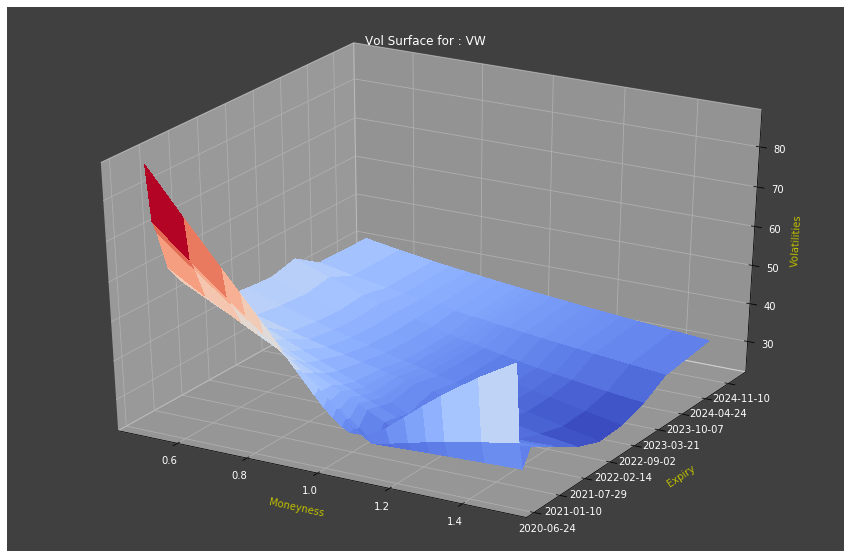

In [6]:
surfaces = eti_response.data.raw['data']
plot_surface(surfaces, 'VW')

### Smile Curve
I can also use the same surfaces response data to plot a Smile Curve.

For example, to compare the volatility smiles of the 4 equities at the chosen expiry time (where the maturity value of 1 is the first expiry):

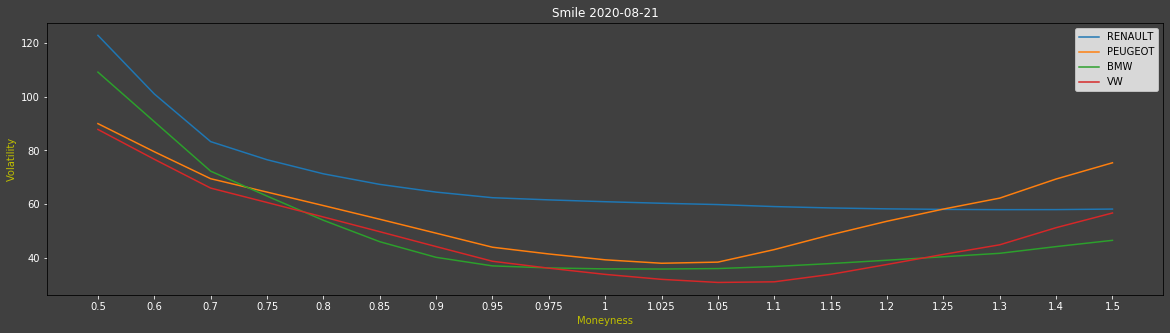

In [7]:
plot_smile(surfaces, 1)

### Volatility Terms
We can also use the same surfaces response data to plot the Term Structure (the full code for all the plots can be found in the plotting_helper file)

Let the user to choose the Moneyness index - **integer value** - to use for the chart:

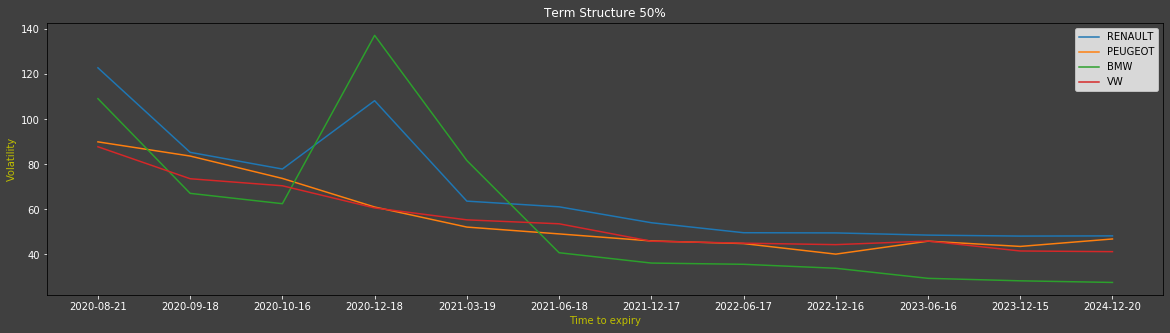

In [8]:
moneyness=1 
plot_term_volatility(surfaces, moneyness)

### Equity Volatility Surface - advanced usage

Let's dig deeper into some advanced parameters for ETI volaitlity surfaces.

The request is highly configurable and the various parameters & options are listed on the API playground. For example, the options are :
* Timestamp : Default, Close, Settle
* Volatility Model : SVI or SSVI (Surface SVI)
* Input : Quoted or Implied


In [9]:
eti_advanced_request_body={
 "universe": [
        {   "surfaceTag": "ANZ",
            "underlyingType": "Eti",
            "underlyingDefinition": {
                "instrumentCode": "ANZ.AX"
            },
            "surfaceParameters": {
                "timestamp" :"Close",
                "volatilityModel": "SSVI",
                "inputVolatilityType": "Quoted",
                "xAxis": "Date",
                "yAxis": "Moneyness"
            },
            "surfaceLayout": {  "format": "Matrix" }
        }]
}

eti_advanced_response = vs_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = eti_advanced_request_body
)

print(json.dumps(eti_advanced_response.data.raw, indent=2))

{
  "data": [
    {
      "surfaceTag": "ANZ",
      "surface": [
        [
          null,
          "0.5",
          "0.6",
          "0.7",
          "0.75",
          "0.8",
          "0.85",
          "0.9",
          "0.95",
          "0.975",
          "1",
          "1.025",
          "1.05",
          "1.1",
          "1.15",
          "1.2",
          "1.25",
          "1.3",
          "1.4",
          "1.5"
        ],
        [
          "2020-08-20",
          54.861224649916,
          50.0268555806178,
          45.5560268891789,
          43.4154346527773,
          41.3226712577016,
          39.270463370258604,
          37.2567692195306,
          35.2896608671714,
          34.331764128526,
          33.4005512237713,
          32.5093578747168,
          31.6797873041888,
          30.3473032522573,
          29.6998471997294,
          29.7018923439376,
          30.0422835455606,
          30.5156495284451,
          31.5629833597805,
          32.594959546874605


Once again, I extract the payload and plot my surface for 'ANZ'.

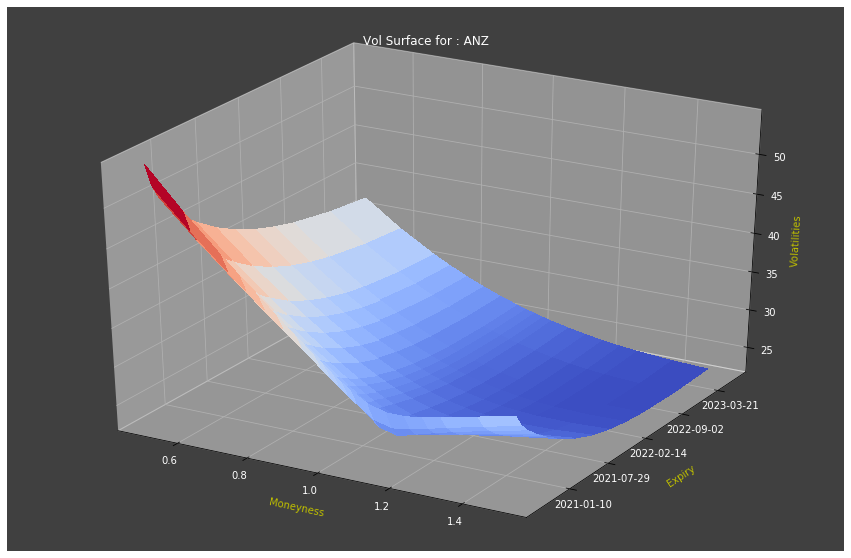

In [10]:
surfaces = eti_advanced_response.data.raw['data']
plot_surface(surfaces, 'ANZ')

### Equity Volatility Surface - Weights and Goodness of Fit
In this section, I will apply my own weights per moneyness range and check the goodness of fit.

I will keep the same ANZ request and simply add my weighting assumptions:
* Options with moneyness below 50% will have a 0.5 weight
* Options with moneyness above 150% will have a 0.1 weight
* All other options will have a higher weight of 1

In [11]:
eti_weights_request_body={
 "universe": [
        {   "surfaceTag": "ANZ_withWeights",
            "underlyingType": "Eti",
            "underlyingDefinition": {
                "instrumentCode": "ANZ.AX"
            },
            "surfaceParameters": {
                "timestamp" :"Close",
                "volatilityModel": "SSVI",
                "inputVolatilityType": "Quoted",
                "xAxis": "Date",
                "yAxis": "Moneyness",
                "weights":[
                  {
                    "minMoneyness": 0,
                    "maxMoneyness": 50,
                    "weight":0.5
                  },
                  {
                    "minMoneyness": 50,
                    "maxMoneyness": 150,
                    "weight":1
                  },
                  {
                    "minMoneyness": 150,
                    "maxMoneyness": 200,
                    "weight":0.1
                  }
                ]
            },
            "surfaceLayout": {  "format": "Matrix" }
        }],
    "outputs":["GoodnessOfFit"]
}

eti_weights_response = vs_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = eti_weights_request_body
)

print(json.dumps(eti_weights_response.data.raw, indent=2))

{
  "data": [
    {
      "surfaceTag": "ANZ_withWeights",
      "surface": [
        [
          null,
          "0.5",
          "0.6",
          "0.7",
          "0.75",
          "0.8",
          "0.85",
          "0.9",
          "0.95",
          "0.975",
          "1",
          "1.025",
          "1.05",
          "1.1",
          "1.15",
          "1.2",
          "1.25",
          "1.3",
          "1.4",
          "1.5"
        ],
        [
          "2020-08-20",
          54.7201773847392,
          49.8719810506438,
          45.384769559209,
          43.2346257668313,
          41.131103080878404,
          39.0666379355383,
          37.0388912238989,
          35.0558892706322,
          34.0896528300624,
          33.150454081216104,
          32.2528419258465,
          31.420904617053203,
          30.114362215872198,
          29.5466805480255,
          29.626779567541302,
          30.014534486025802,
          30.514967712089803,
          31.5893965993641,
    

Once again, I extract the payload and plot my new surface for 'ANZ'

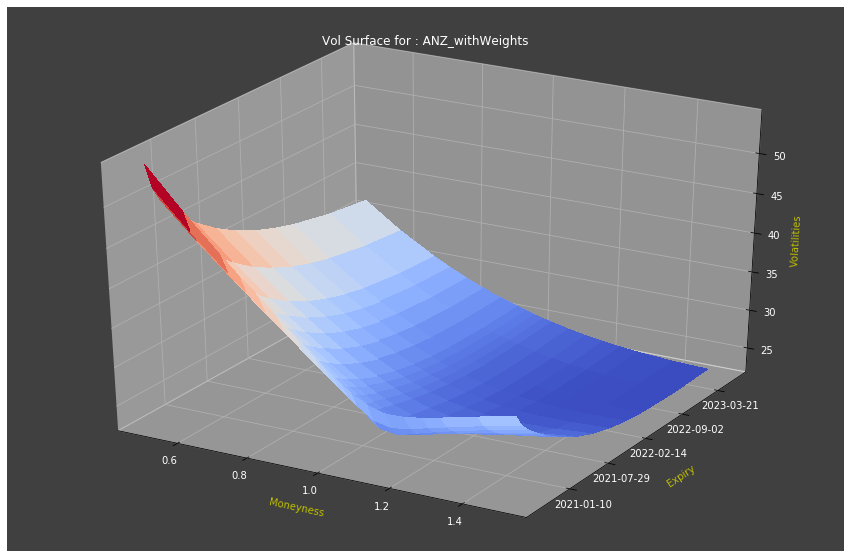

In [12]:
surfaces = eti_weights_response.data.raw['data']
plot_surface(surfaces, 'ANZ_withWeights')

Since we changed the weights, I might want to view the Goodness Of Fit for this new generated surface.

In [13]:
pd.DataFrame(data=surfaces[0]["goodnessOfFit"])

,0,1,2,3,4
0,Expiry,Is Calibrated,Average Spread Explained,Min Strike,Max Strike
1,2020-08-20,1,0.502539,12.5,29
2,2020-09-17,1,0.726255,10,33
3,2020-10-15,1,0.762567,13.25,27.5
4,2020-11-19,1,0.728841,14.75,24.5
5,2020-12-17,1,0.737129,7.5,34
6,2021-01-21,1,0.69625,14.75,22
7,2021-03-18,1,0.67881,10,33
8,2021-06-17,1,0.642048,12,34
9,2021-09-16,1,0.886477,12,33


### FX Volatility Surface
I can also use the same IPA Endpoint to request FX Volatility Surfaces 

For example the request below, will allow me to generate an FX volatility surface:

for USDSGD cross rates  
express the axes in Dates and Delta  
and return the data in a matrix format  

As I mentioned earlier,  the request is configurable and the parameters & options are listed on the API playground. 
For example, some of the parameters I could have used and their current options:

* Volatility Model : SVI, SABR or CubicSpline
* Axes : Delta/Strike and Tenor/Date
* Data format : Matrix or List

The ***calculationDate*** defaults to today's date and can be overridden - as I have done below: 


In [14]:
fx_request_body={
    "universe": [
        {
              "underlyingType": "Fx",
              "surfaceTag": "FxVol-USDSGD",
              "underlyingDefinition": {
                "fxCrossCode": "USDSGD"
              },
              "surfaceLayout": {
                "format": "Matrix"
              },
              "surfaceParameters": {
                "xAxis": "Date",
                "yAxis": "Delta",
                "calculationDate": "2018-08-20T00:00:00Z"
              }
        }
    ]
}

fx_response = vs_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = fx_request_body
)

print(json.dumps(fx_response.data.raw, indent=2))

{
  "data": [
    {
      "surfaceTag": "FxVol-USDSGD",
      "surface": [
        [
          null,
          -0.1,
          -0.15,
          -0.2,
          -0.25,
          -0.3,
          -0.35,
          -0.4,
          -0.45,
          0.0,
          0.45,
          0.4,
          0.35,
          0.3,
          0.25,
          0.2,
          0.15,
          0.1
        ],
        [
          "2018-08-27T00:00:00Z",
          4.974518945103927,
          4.924790304724133,
          4.895074247084674,
          4.877100340773841,
          4.8673370792198485,
          4.8640702280773125,
          4.86647347618808,
          4.874251953955435,
          4.887499999999665,
          4.9070665849568815,
          4.933718749943821,
          4.969007632573339,
          5.015441888323992,
          5.0771766434118115,
          5.1615471156127,
          5.282968328602074,
          5.475356718951845
        ],
        [
          "2018-09-20T00:00:00Z",
          4.83721316901314

Once again, I extract the payload and plot my surface - below I extract and plot the Volatility Surface for 'Singapore Dollar / US Dollar'.

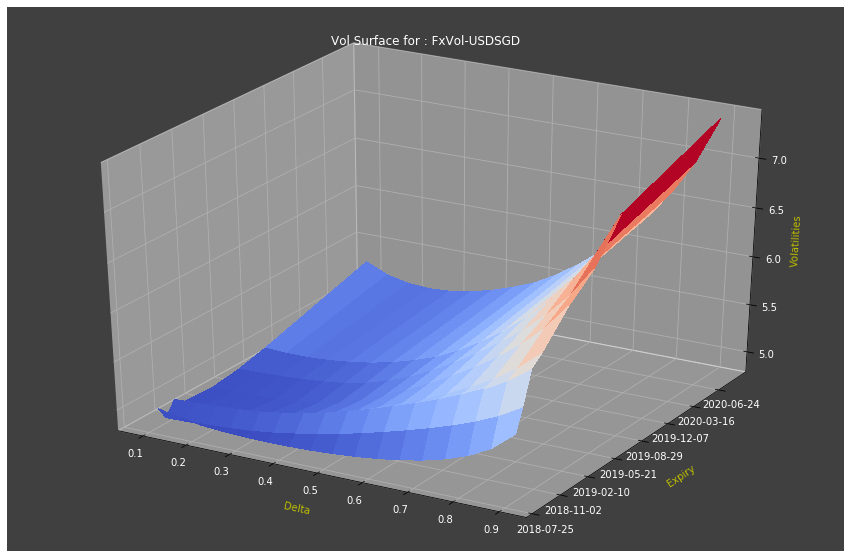

In [15]:
fx_surfaces = fx_response.data.raw['data']
plot_surface(fx_surfaces, 'FxVol-USDSGD', True)

### Let's use the Surfaces to price OTC options
Now that we know how to build a surface, we will see how we can use them to price OTC contracts.

In [16]:
fc_endpoint = rdp.Endpoint(session, 
            "https://api.refinitiv.com/data/quantitative-analytics/v1/financial-contracts")

In the request below, I will price two OTC 'ANZ' options: 

In [17]:
option_request_body = {
    "fields": ["InstrumentTag","ExerciseType","OptionType","ExerciseStyle","EndDate","StrikePrice",\
               "MarketValueInDealCcy","VolatilityPercent","DeltaPercent","ErrorMessage"],
    
    "universe":[{
        
        "instrumentType": "Option",
        "instrumentDefinition": {
            "instrumentTag" :"ANZ 15Jan 20",
            "underlyingType": "Eti",
            "strike": 20,
            "endDate": "2021-01-15",
            "callPut": "Call",
            "underlyingDefinition": {
                "instrumentCode": "ANZ.AX"
            }
        }
    },
    {
        "instrumentType": "Option",
        "instrumentDefinition": {
            "instrumentTag" :"ANZ 15Jan 21",
            "underlyingType": "Eti",
            "strike": 21,
            "endDate": "2021-01-15",
            "callPut": "Call",
            "underlyingDefinition": {
                "instrumentCode": "ANZ.AX"
            }
        }
    }],     

    "pricingParameters": {
        "timeStamp" : "Close"
    },
        
    "outputs": ["Data","Headers"]
}

fc_response = fc_endpoint.send_request(
    method = rdp.Endpoint.RequestMethod.POST,
    body_parameters = option_request_body
)

print(json.dumps(fc_response.data.raw, indent=2))

{
  "headers": [
    {
      "type": "String",
      "name": "InstrumentTag"
    },
    {
      "type": "String",
      "name": "ExerciseType"
    },
    {
      "type": "String",
      "name": "OptionType"
    },
    {
      "type": "String",
      "name": "ExerciseStyle"
    },
    {
      "type": "DateTime",
      "name": "EndDate"
    },
    {
      "type": "Float",
      "name": "StrikePrice"
    },
    {
      "type": "Float",
      "name": "MarketValueInDealCcy"
    },
    {
      "type": "Float",
      "name": "VolatilityPercent"
    },
    {
      "type": "Float",
      "name": "DeltaPercent"
    },
    {
      "type": "String",
      "name": "ErrorMessage"
    }
  ],
  "data": [
    [
      "ANZ 15Jan 20",
      "CALL",
      "Vanilla",
      "EURO",
      "2021-01-15T00:00:00Z",
      20.0,
      0.681035763342642,
      25.0646965389153,
      0.350874539459014,
      ""
    ],
    [
      "ANZ 15Jan 21",
      "CALL",
      "Vanilla",
      "EURO",
      "2021-01-15T00:00:

In [18]:
headers_name = [h['name'] for h in fc_response.data.raw['headers']]
pd.DataFrame(data=fc_response.data.raw['data'], columns=headers_name)

,InstrumentTag,ExerciseType,OptionType,ExerciseStyle,EndDate,StrikePrice,MarketValueInDealCcy,VolatilityPercent,DeltaPercent,ErrorMessage
0,ANZ 15Jan 20,CALL,Vanilla,EURO,2021-01-15T00:00:00Z,20.0,0.681036,25.064697,0.350875,
1,ANZ 15Jan 21,CALL,Vanilla,EURO,2021-01-15T00:00:00Z,21.0,0.447139,25.297217,0.254477,
